<H1>Distribution Mixture Model via Expectation Maximization</H1>

In [ ]:
%%capture
!pip install unidip

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from unidip import UniDip
from scipy.stats import norm

<h3>
Generate two synthetic data signals that simulate processes producing metrics data following simple Normal distributions.
</h3>

In [ ]:
# Generate two synthetic data signals that simulate processes producing metrics data following simple Normal distributions.

# Create two different Normal distribution objects that generate numbers
signal1_Mean = 5
signal1_StandardDeviation = 2
signalGenerator1 =  np.random.default_rng(123)
signal1Data = signalGenerator1.normal(signal1_Mean, signal1_StandardDeviation, size=300)

signal2_Mean = 21
signal2_StandardDeviation = 2
signalGenerator2 = np.random.default_rng(345) 
signal2Data = signalGenerator2.normal(signal2_Mean, signal2_StandardDeviation, size=100)

<h3>
Now create a data mixture by combining the two signals into a single signal
</h3>

In [ ]:
# Now create a data mixture by combining the two signals into a single signal
mixedSignalData = np.random.permutation(np.append(signal1Data, signal2Data))
mixedMin = mixedSignalData.min()
mixedMax = mixedSignalData.max()

<h3>
Visualize the mixed signal data
</h3>

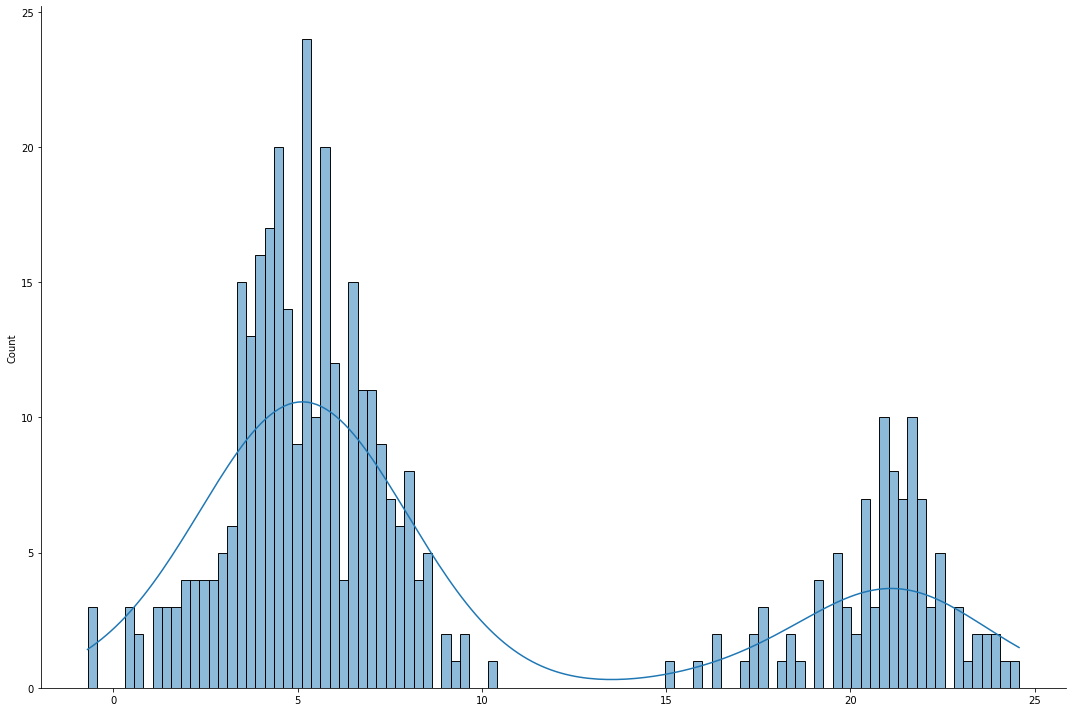

In [ ]:
# Visualize the mixed signal data
x_axis = np.linspace(mixedMin, mixedMax, 1000)
sns.displot(mixedSignalData, bins=100, kde=True, height=10, aspect=15/10)

<h3>
Find modes in the mixed signals using UniDip
<br>
Mode count (peaks count) can indicate how many source signals are mixed together into a single mixed signal
</h3>

In [ ]:
# Find modes in the mixed signals using UniDip
# Mode count (peaks count) can indicate how many source signals are mixed together into a single mixed signal

# sort data so returned indices are meaningful
sortedMixedData = np.msort(mixedSignalData)

# get start and stop indices of peaks 
intervals = UniDip(sortedMixedData, alpha=0.05).run()

print(len(intervals), 'modes found:', intervals)
for interval in intervals:
    print(interval, '=', sortedMixedData[interval[0]], '-', sortedMixedData[interval[1]])

2 modes found: [(31, 291), (303, 397)]



(31, 291) = 2.813936380720848 - 8.44459064912692



(303, 397) = 16.414805537023195 - 24.073692775516896


<h3>
Visualize the mixed signal data with mode ranges highlighted
</h3>

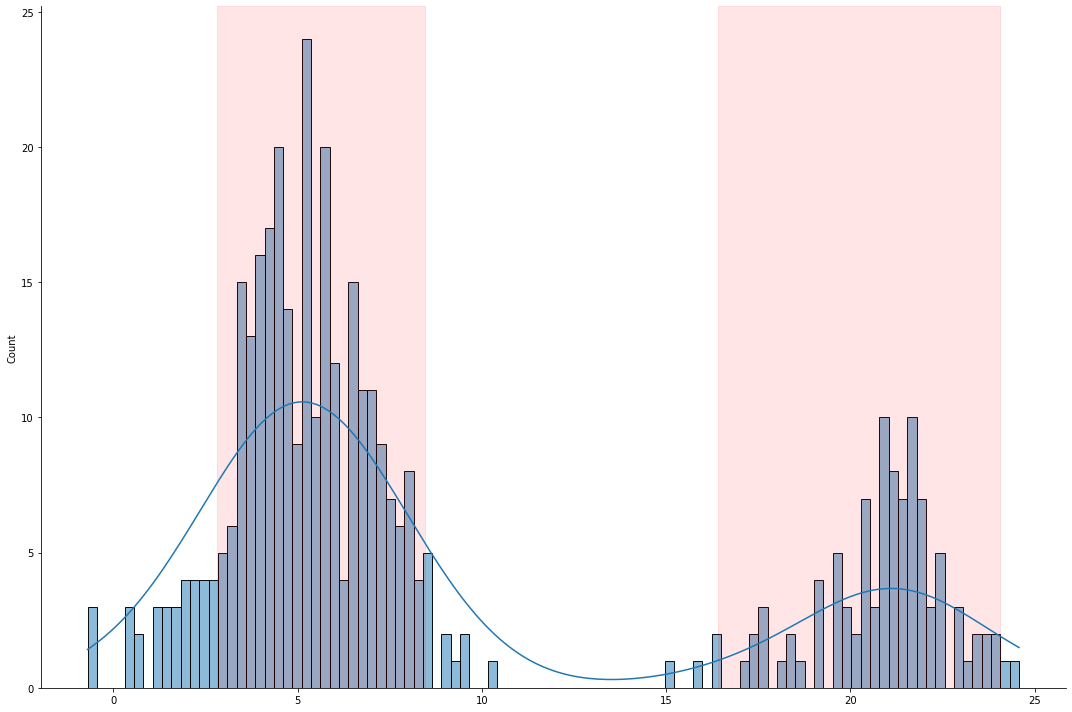

In [ ]:
# Visualize the mixed signal data with mode ranges highlighted
x_axis = np.linspace(mixedMin, mixedMax, 1000)
g = sns.displot(mixedSignalData, bins=100, kde=True, height=10, aspect=15/10)
for interval in intervals:
    g.fig.get_axes()[0].axvspan(sortedMixedData[interval[0]], sortedMixedData[interval[1]], alpha=0.1, color='red')

<h3>
Now lets automatically fit multiple distributions to the mixed signals using the output data from UniDip via Expectation Maximization algorithm
</h3>

In [ ]:
# Now lets automatically fit multiple distributions to the mixed signals using the output data from UniDip via Expectation Maximization algorithm
class ExpectationMaximization:
    def __init__(self, data, mean=[10, 10], std=[1, 1], mix=[0.5, 0.5], mode_count=2):
        self.data = data
        # discovered mean for each mode
        self.mean = mean
        # discovered std for each mode
        self.std = std
        # discovered proportions of total data points for each mode
        self.mix = mix
        self.mode_count = mode_count
        self.progressive_adjustments = [np.zeros(mode_count) for d in data]

    def CalcExpectation(self):
        for i, d in enumerate(self.data):
            for mode in range(self.mode_count):
                self.progressive_adjustments[i][mode] = norm.pdf(d, loc=self.mean[mode], scale=self.std[mode]) * \
                                                        self.mix[mode]

        total = np.sum(self.progressive_adjustments, axis=1)

        self.progressive_adjustments /= total[:, np.newaxis]

    def CalcMaximization(self):
        for mode in range(self.mode_count):
            total = self.progressive_adjustments[:, mode].sum()
            adjustments = [adj * d for (adj, d) in zip(self.progressive_adjustments[:, mode], self.data)]
            self.mean[mode] = np.sum(adjustments) / total
            adjustments = [adj * ((d - self.mean[mode]) ** 2) for (adj, d) in zip(self.progressive_adjustments[:, mode], self.data)]
            self.std[mode] = np.sqrt(np.sum(adjustments) / total)
            self.mix[mode] = total / len(self.data)
            
    def GetModeMembership(self):
        members = {key:[] for key in range(self.mode_count)}
        for i, d in enumerate(np.msort(self.data)):
            predictions = []
            for mode in range(self.mode_count):
                predictions.append(norm.pdf(d, loc=self.mean[mode], scale=self.std[mode]) * self.mix[mode])
            members[np.argmax(predictions)].append(i)
        return members
                

<h3>
Print out the actual summary statistics of the signal data.
</h3>

In [ ]:
print('signal1Data mean', signal1Data.mean())
print('signal1Data std', signal1Data.std())
print('signal2Data mean', signal2Data.mean())
print('signal2Data std', signal2Data.std())

signal1Data mean 5.079328291474317



signal1Data std 1.9350933437080244



signal2Data mean 20.800835137583167



signal2Data std 1.8549483070938695


<h3>
Now run the Expectation Maximization process and print out the results
</h3>

In [ ]:
means = []
stds = []
mixes = []
for interval in intervals:
    data = sortedMixedData[interval[0]:interval[1] + 1]
    means.append(data.mean())
    stds.append(data.std())
    mixes.append(1 / len(intervals))
    
print('Starting values used as initialization params for EM:')
print('means', means)
print('standard deviations', stds)
print('mix proportions', mixes)

em = ExpectationMaximization(mixedSignalData, mean=means, std=stds, mix=mixes, mode_count=len(intervals))

# Run EM enough times to achieve convergence
for i in range(10):
    em.CalcExpectation()
    em.CalcMaximization()

print('====================================================')
print('Values discovered by EM from the data for each mode:')
print('means', em.mean)
print('standard deviations', em.std)
print('mix proportions', em.mix)


Starting values used as initialization params for EM:



means [5.380207450195101, 20.8835467773311]



standard deviations [1.4262178518403046, 1.5983602357073976]



mix proportions [0.5, 0.5]






Values discovered by EM from the data for each mode:



means [5.079340184521459, 20.80085458981205]



standard deviations [1.935123460167058, 1.854922531219534]



mix proportions [0.7500008766866995, 0.24999912331330043]


In [ ]:
members = em.GetModeMembership()

<h3>
Visualize data points predicted for each mode by EM.
</h3>

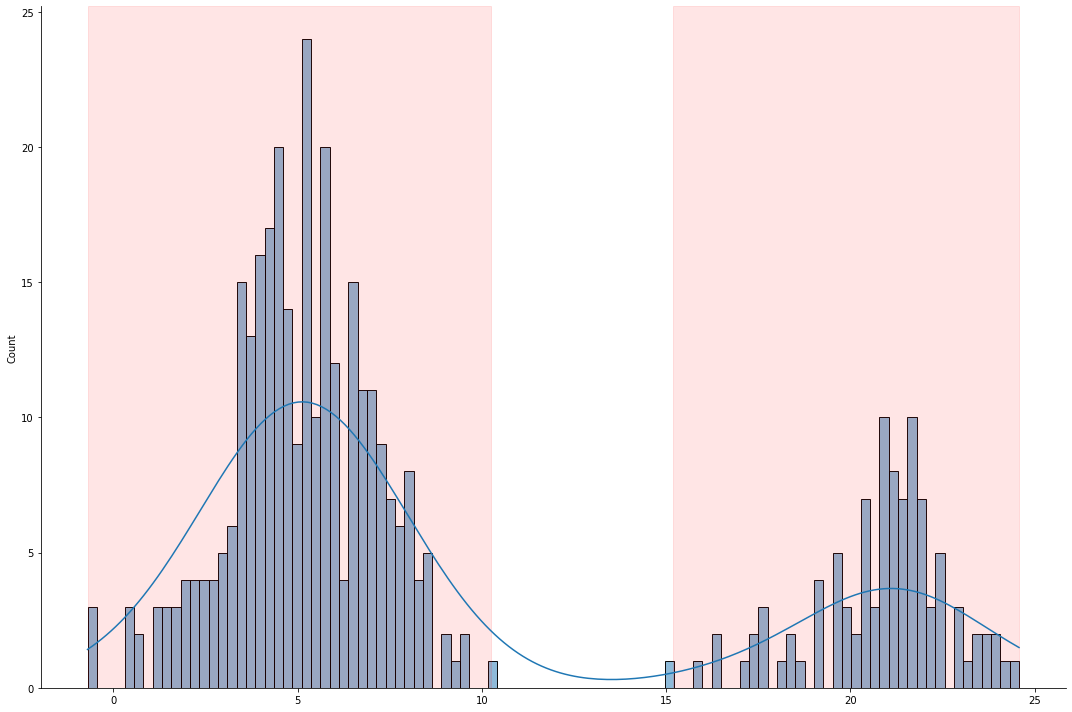

In [ ]:
x_axis = np.linspace(mixedMin, mixedMax, 1000)
g = sns.displot(mixedSignalData, bins=100, kde=True, height=10, aspect=15/10)
for key in members.keys():
    modeMin = np.min(members[key])
    modeMax = np.max(members[key])
    g.fig.get_axes()[0].axvspan(sortedMixedData[modeMin], sortedMixedData[modeMax], alpha=0.1, color='red')